In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import ImageShow, Image
from IPython.display import display
import numpy as np

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/potatodata/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

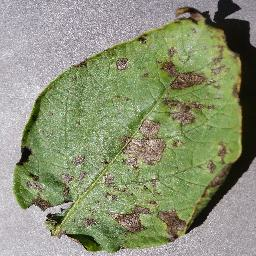

Potato___Early_blight


In [ ]:
for image_batch, label_batch in dataset.take(1):
  image = Image.fromarray(image_batch[0].numpy().astype("uint8"))
  display(image)
  print(class_names[label_batch[0]])

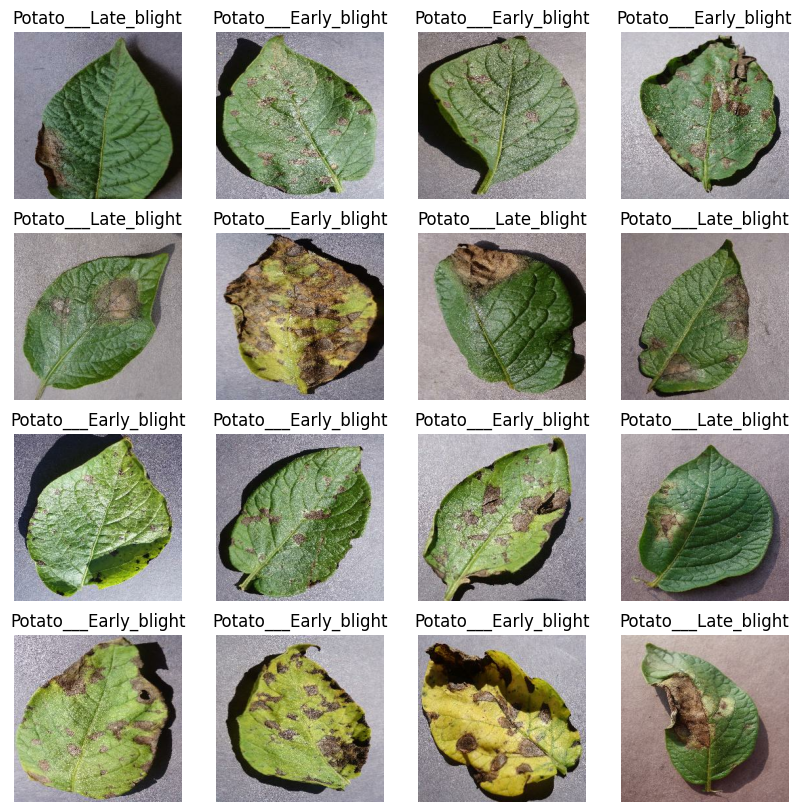

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(dataset)

68

In [ ]:
def get_dataset_partioned_datasets(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 9)

  train_size = ds_size * train_split
  val_size = ds_size * val_split
  test_size = ds_size * test_split

  train_ds = ds.take(int(train_size))
  val_ds = ds.skip(int(train_size)).take(int(val_size))
  test_ds = ds.skip(int(train_size)).skip(int(val_size))
  # test_ds = ds.skip(int(train_size) + int(val_size)) Also possible

  return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partioned_datasets(dataset)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="HORIZONTAL_AND_VERTICAL"),
    tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Lets train the Model

In [ ]:
n_classes = 3
BATCH_SIZE = 32
IMAGE_SIZE = 256

model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),
    resize_and_rescale,
    keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')
])

model.build()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,762,307 (14.35 MB)

 Trainable params: 3,762,307 (14.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 15,
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 748s 474ms/step - accuracy: 0.6174 - loss: 0.9178 - val_accuracy: 0.8542 - val_loss: 0.3701
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.8623 - loss: 0.3433 - val_accuracy: 0.8906 - val_loss: 0.2518
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.9085 - loss: 0.2468 - val_accuracy: 0.9167 - val_loss: 0.2029
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.9448 - loss: 0.1429 - val_accuracy: 0.9271 - val_loss: 0.1856
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.9456 - loss: 0.1367 - val_accuracy: 0.9167 - val_loss: 0.2080
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.9477 - loss: 0.1393 - val_accuracy: 0.8333 - val_loss: 0.4527
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.9304 - loss: 0.1704 - val_accuracy: 0.8021 - val_loss: 0.6199
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.9470 - loss: 0.1364 - val_acc

In [ ]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9582 - loss: 0.1058


In [ ]:
score

[0.10009501129388809, 0.9698275923728943]

Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
Predicted label :  Potato___Late_blight


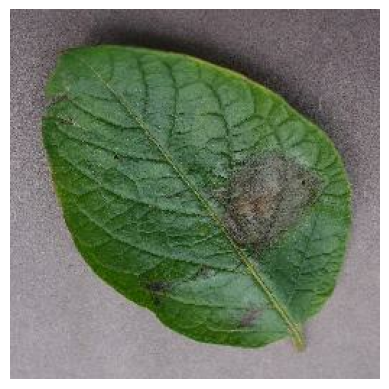

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  plt.imshow(first_image)
  plt.axis("off")
  print(class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label : ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


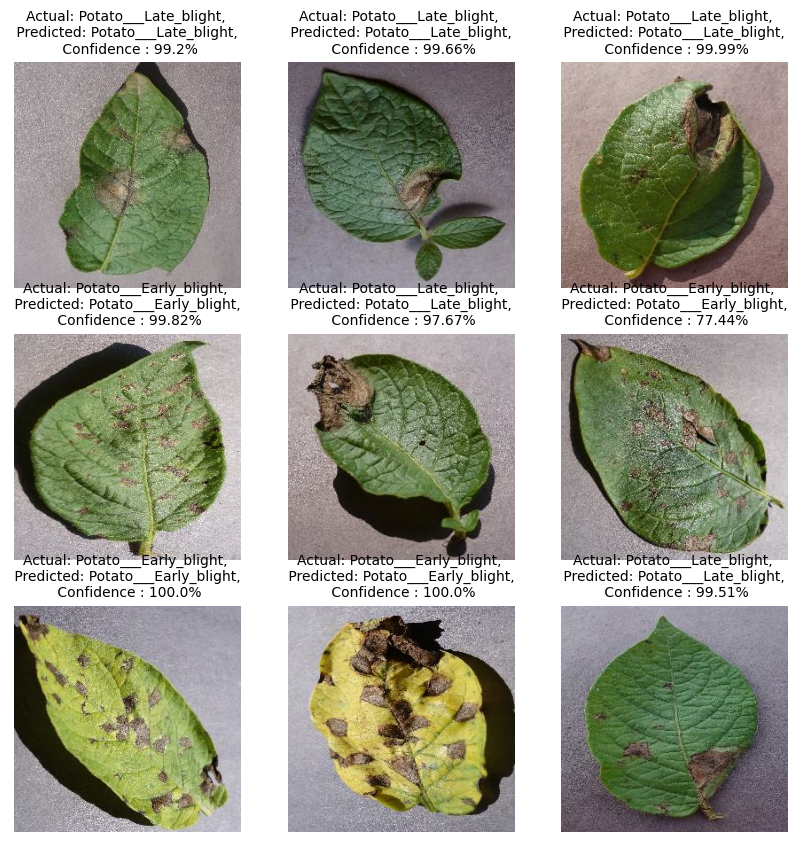

In [ ]:
plt.figure(figsize = (10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence : {confidence}%",
              fontsize=10)

    plt.axis("off")

In [ ]:
import os
items = os.listdir("/content/drive/MyDrive/SavedModels/PotatoDiseasePredictior")

numeric_items = [int(item) for item in items if item.isdigit()]
numeric_items.append(0)
model_version = max(numeric_items) + 1

model.save(f"/content/drive/MyDrive/SavedModels/PotatoDiseasePredictior/{model_version}.keras")